In [27]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from matplotlib import pyplot as plt

import util
reload(util);

import luna_util
reload(luna_util);

import luna_preprocess
reload(luna_preprocess);

In [4]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

array([  3.2534432 ,   6.43360048,  32.27003025])

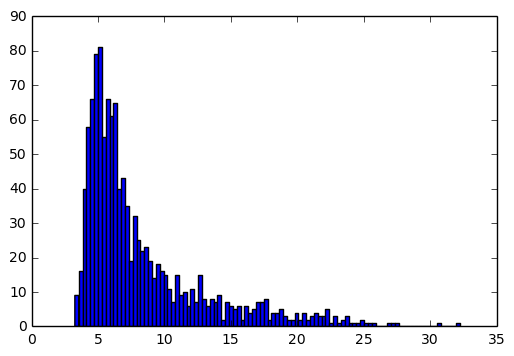

In [5]:
plt.hist(annt_df['diameter_mm'], bins=100);
np.percentile(annt_df['diameter_mm'], [0, 50, 100])

In [ ]:
def sample_file_ids(min_num_nodules=1):
    t = annt_df.groupby('file').count()
    t = set([luna_preprocess.get_file_id(x)
             for x in list(t[t.seriesuid>min_num_nodules].index)])
    t1 = [x[0:-11] for x in os.listdir('../LUNA16/output')]
    return list(set(t1).intersection(t))

In [ ]:
file_ids = sample_file_ids(1)

In [ ]:
file_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276'

In [ ]:
image = luna_preprocess.Image()
image.init(file_dict[file_id], annt_df,
           iso_spacing=1.0, shrink_margin=2.0)

In [ ]:
image = luna_preprocess.Image()
image.load('../LUNA16/output', file_id)

In [ ]:
nodules = image.get_v_nodules()
print '# of nodules = %d'%len(nodules)

In [ ]:
nodule_idx = 0
nodule = nodules[nodule_idx]

In [ ]:
x, y, z, d = nodule
plt.figure()
plt.imshow(image.masked_lung[z], cmap='gray')
circle = plt.Circle((x, y), d/2, color='r', fill=False)
plt.gca().add_artist(circle)
plt.figure()
plt.imshow(image.masked_nodule(nodule_idx)[z], cmap='gray')

In [ ]:
sigmas = util.get_dot_enhance_filter_sigmas(d0=3, d1=33, N=5)

In [ ]:
enhance_2d = util.enhance_filter_2d(image.masked_lung[z], sigmas, 'dot')

In [ ]:
plt.imshow(enhance_2d>20, cmap='gray')
circle = plt.Circle((x, y), d, color='r', fill=False)
plt.gca().add_artist(circle)

In [ ]:
enhance_3d = util.enhance_filter_3d(image.masked_lung, sigmas, 'dot')

In [ ]:
plt.imshow(enhance_3d[z]>20, cmap='gray')
circle = plt.Circle((x, y), d/2, color='r', fill=False)
plt.gca().add_artist(circle)
plt.figure()
plt.imshow(image._nodule_masks[nodule_idx][z], cmap='gray')

In [ ]:
labels = measure.label(enhance_3d>20)

In [ ]:
vals, counts = np.unique(labels, return_counts=True)

In [ ]:
vol_min = np.pi * 4.0 / 3 * (d0/2.0)**3 * 0.9
vol_max = np.pi * 4.0 / 3 * (d1/2.0)**3 * 1.1

In [ ]:
idx = ((counts>=vol_min)&(counts<=vol_max))
vals = vals[idx]
counts = counts[idx]

In [ ]:
print '# of clusters = %d'%len(vals)

In [ ]:
label = vals[0]
slices = util.find_bbox((labels==label), margin=[0,0,0], bg=0)
slices

In [ ]:
ref_mask = image._nodule_masks[nodule_idx]

cand_labels = vals
overlaps = []
for cand_label in cand_labels:
    mask = (labels==cand_label)
    i = np.sum(np.logical_and(mask, ref_mask))
    u = np.sum(mask) + np.sum(ref_mask) - i
    overlaps.append(i / float(np.sum(mask)))

In [ ]:
np.argmax(overlaps), max(overlaps)

In [ ]:
mask = (labels==cand_labels[np.argmax(overlaps)])
[
    np.sum(np.logical_and(mask, ref_mask)),
    np.sum(mask),
    np.sum(ref_mask)
]

In [ ]:
mask = (labels==cand_labels[np.argmax(overlaps)])

In [ ]:
plt.imshow(image.masked_lung[z], cmap='gray')
plt.figure()
plt.imshow(mask[z], cmap='gray')

In [125]:
root_dir = '../LUNA16/output_enhance'
enhance_3d_file_list = [
    os.path.join(root_dir, f)
    for f in os.listdir(root_dir)
]

In [132]:
def eval_enhance_3d_quality(enhance_3d_file, d0, d1, th):
    image = luna_preprocess.Image()
    image.load(luna_preprocess.get_file_id(enhance_3d_file))
    enhance_3d = np.load(enhance_3d_file).items()[0][1]
    
    sigmas = util.get_dot_enhance_filter_sigmas(d0=d0, d1=d1, N=5)
    vol_min = np.pi * 4.0 / 3 * (d0/2.0)**3 * 0.9
    vol_max = np.pi * 4.0 / 3 * (d1/2.0)**3 * 1.1
    
    labels = measure.label(enhance_3d>th)
    vals, counts = np.unique(labels, return_counts=True)
    cand_labels = vals[((counts>=vol_min)&(counts<=vol_max))]
    
    nodules = image.get_v_nodules()
    num_nodules = len(nodules)
    
    def eval_nodule(nod_idx):
        nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodules[nod_idx]
        ref_mask = image._nodule_masks[nod_idx]
        overlaps = []
        for cand_label in cand_labels:
            mask = (labels==cand_label)
            i = np.sum(np.logical_and(mask, ref_mask))
            u = np.sum(mask) + np.sum(ref_mask) - i
            overlaps.append(i / float(np.sum(mask)))
        return max(overlaps)
    
    return ([
        eval_nodule(nod_idx)
        for nod_idx in range(num_nodules)
    ], len(cand_labels))

In [152]:
ans = []
for enhance_3d_file in enhance_3d_file_list:
    ans.append(eval_enhance_3d_quality(enhance_3d_file, d0=3, d1=33, th=3))

In [138]:
import pickle
with open('ans.dat', 'w') as f:
    pickle.dump(ans, f)

In [153]:
x = [b for a, c in ans for b in a]

In [154]:
len(x) * 1.0 /sum([c for a, c in ans])

0.001820969906076289

In [158]:
sum(np.array(x)>0.2) / float(len(x))

0.9064327485380117

In [160]:
ans

[([0.83858267716535428, 1.0, 1.0], 1219),
 ([1.0, 0.85512367491166075, 0.875, 0.93103448275862066, 0.43352601156069365],
  1357),
 ([0.9932432432432432, 0.77828054298642535], 2207),
 ([0.98701298701298701, 0.49193548387096775], 2026),
 ([0.96648044692737434,
   0.92391304347826086,
   1.0,
   1.0,
   0.41025641025641024,
   0.84507042253521125],
  2244),
 ([0.8031774051191527,
   0.39215686274509803,
   0.82337662337662343,
   0.85851318944844124,
   0.31343283582089554,
   0.57793764988009588],
  2106),
 ([0.50877192982456143, 0.41772151898734178], 1366),
 ([0.83076923076923082, 1.0], 1345),
 ([0.97101449275362317, 0.88495575221238942, 0.0, 0.82568807339449546], 1408),
 ([0.65296803652968038, 0.52000000000000002, 0.59493670886075944, 0.0], 1776),
 ([0.875, 0.66417910447761197, 0.55172413793103448, 0.98995363214837717],
  1982),
 ([0.83823529411764708,
   0.56538461538461537,
   0.33423913043478259,
   0.24087591240875914,
   0.9285714285714286,
   0.95945945945945943],
  1785),
 ([0.9

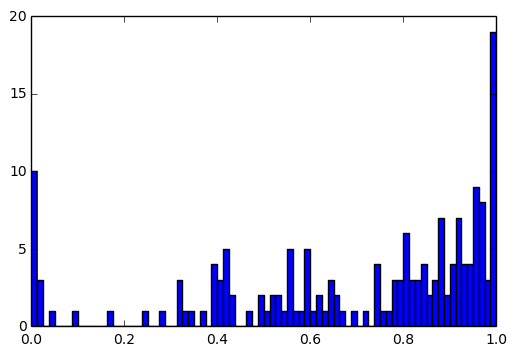

In [161]:
plt.hist(x, bins=80);

In [32]:
d0=3
d1=33
th=20
image = luna_preprocess.Image()
image.load(luna_preprocess.get_file_id(enhance_3d_file))
enhance_3d = np.load(enhance_3d_file).items()[0][1]
labels = measure.label(enhance_3d>th)

In [65]:
sigmas = util.get_dot_enhance_filter_sigmas(d0=d0, d1=d1, N=5)
vol_min = np.pi * 4.0 / 3 * (d0/2.0)**3 * 0.9
vol_max = np.pi * 4.0 / 3 * (d1/2.0)**3 * 1.1
    
nod_idx = 3
nod_v_x, nod_v_y, nod_v_z, nod_v_d = image.get_v_nodules()[nod_idx]

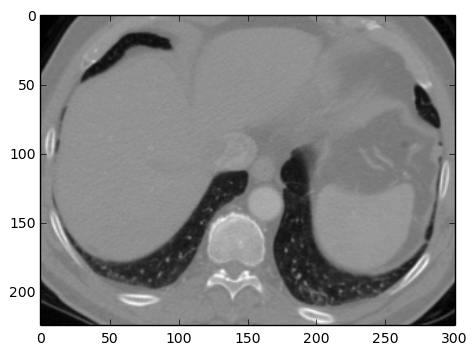

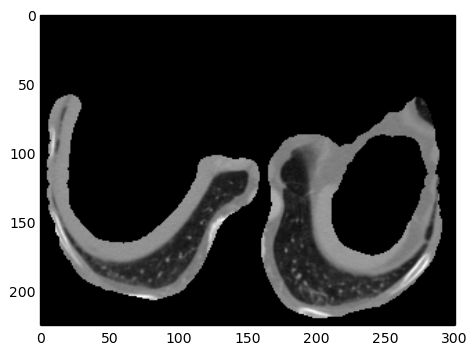

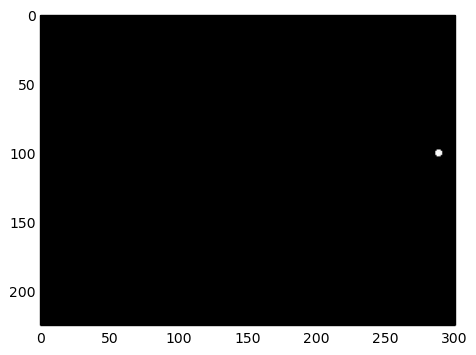

In [78]:
slice_z = nod_v_z-3
plt.figure()
plt.imshow(image._image[slice_z], cmap='gray')
plt.figure()
plt.imshow(image.masked_lung[slice_z], cmap='gray')
circle = plt.Circle((nod_v_x, nod_v_y), nod_v_d/2, color='r', fill=False)
#plt.gca().add_artist(circle)
plt.figure()
plt.imshow(image.masked_nodule(nod_idx)[slice_z], cmap='gray')

In [50]:
enhance_2d = util.enhance_filter_2d(image.masked_lung[nod_v_z], sigmas, 'dot')

util.py:362: RuntimeWarning: invalid value encountered in divide
  ans = np.abs(lambda2)**2 / np.abs(lambda1)


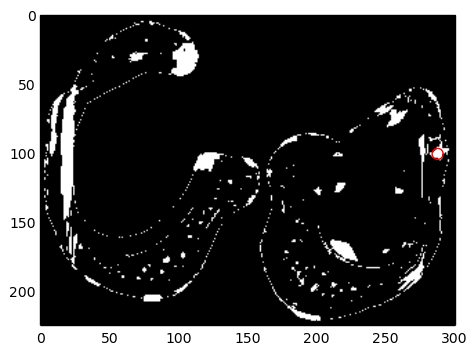

In [89]:
plt.imshow(enhance_2d>20, cmap='gray')
circle = plt.Circle((nod_v_x, nod_v_y), nod_v_d/2, color='r', fill=False)
plt.gca().add_artist(circle)

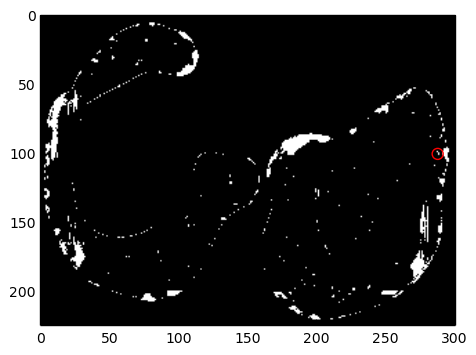

In [117]:
plt.imshow(enhance_3d[nod_v_z]>3, cmap='gray')
circle = plt.Circle((nod_v_x, nod_v_y), nod_v_d/2, color='r', fill=False)
plt.gca().add_artist(circle)

In [92]:
from scipy.ndimage.filters import gaussian_filter

In [103]:
def _enhance_filter_3d_impl(image, sigma, kind):
    bg = image[0, 0, 0]
    fxx = gaussian_filter(image, sigma, order=(0, 0, 2) , mode='constant', cval=bg)
    fyy = gaussian_filter(image, sigma, order=(0, 2, 0) , mode='constant', cval=bg)
    fzz = gaussian_filter(image, sigma, order=(2, 0, 0) , mode='constant', cval=bg)
    fxy = gaussian_filter(image, sigma, order=(0, 1, 1) , mode='constant', cval=bg)
    fyz = gaussian_filter(image, sigma, order=(1, 1, 0) , mode='constant', cval=bg)
    fzx = gaussian_filter(image, sigma, order=(1, 0, 1) , mode='constant', cval=bg)
    a = np.zeros(list(image.shape) + [3, 3])
    a[:,:,:,0,0] = fxx
    a[:,:,:,1,1] = fyy
    a[:,:,:,2,2] = fzz
    a[:,:,:,0,1] = a[:,:,:,1,0] = fxy
    a[:,:,:,1,2] = a[:,:,:,2,1] = fyz
    a[:,:,:,0,2] = a[:,:,:,2,0] = fzx
    w, _ = np.linalg.eig(a)
    w = util.apply_argsort(w, np.argsort(np.abs(w)))
    lambda1 = w[:,:,:,2]
    lambda2 = w[:,:,:,1]
    lambda3 = w[:,:,:,0]
    return lambda1, lambda2, lambda3

In [104]:
sigmas

array([ 0.75      ,  1.36587022,  2.48746859,  4.53007902,  8.25      ])

In [105]:
image._nodules[nod_idx][3]/4.0

1.8571076617500002

In [119]:
ans = _enhance_filter_3d_impl(image.masked_lung, 1.8571076617500002, 'dot')

In [121]:
x = [
    ans[0][nod_v_z, nod_v_y, nod_v_x],
    ans[1][nod_v_z, nod_v_y, nod_v_x],
    ans[2][nod_v_z, nod_v_y, nod_v_x]
]
x

[(-79.8389514405157+0j), (-19.771622919469447+0j), (-6.3894256400148137+0j)]

In [122]:
np.abs(x[2])**2/np.abs(x[0]) * 1.36587022**2

0.95395455998408352

In [123]:
np.abs(x[2])**2/np.abs(x[0]) * 1.8571076617500002**2

1.7635305170803117

In [113]:
enhance_3d[nod_v_z, nod_v_y, nod_v_x]

3.4471288326904941